In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from UnarySim.sw.kernel.add import UnaryAdd
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device = "cuda:0"
# device = "cpu"

In [4]:
rng = "Sobol"
# rng = "Race"

row = 128
col = 10000

mode = "bipolar"
scaled = False
acc_dim = 0

uadd = UnaryAdd(bitwidth=8, mode=mode, scaled=scaled, acc_dim=acc_dim).to(device)

if mode is "unipolar":
    iVec = torch.rand(row, col).mul(256).round().div(256).to(device)
elif mode is "bipolar":
    iVec = torch.rand(row, col).mul(2).sub(1).mul(256).round().div(256).to(device)

oVec = torch.sum(iVec, acc_dim).to(device)

if scaled is False:
    oVec = oVec.clamp(-1.,1.).mul(256).floor()/256
else:
    if acc_dim == 0:
        oVec = oVec.div(row).mul(256).floor()/256
    elif acc_dim == 1:
        oVec = oVec.div(col).mul(256).floor()/256


iVecSource = SourceGen(iVec, bitwidth=8, mode=mode)().to(device)

iVecRNG = RNG(8, 1, rng)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG).to(device)

iVecPE = ProgressiveError(iVec, mode=mode).to(device)
oVecPE = ProgressiveError(oVec, mode=mode).to(device)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    start_time = time.time()
    for i in range(256):
#         print(i)
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)
        
        oVecU = uadd(iBS)
        oVecPE.Monitor(oVecU)
#         print("\n")
    print("--- %s seconds ---" % (time.time() - start_time))
    print("input error: ", torch.min(iVecPE()[1]), torch.max(iVecPE()[1]))
    print("output error: ", torch.min(oVecPE()[1]), torch.max(oVecPE()[1]))
    result_pe = oVecPE()[1].cpu().numpy()
    print(result_pe)

--- 0.2656126022338867 seconds ---
tensor([0, 0, 1,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
input error:  tensor(-0.0078, device='cuda:0') tensor(0.0039, device='cuda:0')
output error:  tensor(-0.9570, device='cuda:0') tensor(0.2031, device='cuda:0')
[ 0.046875   0.015625  -0.109375  ...  0.        -0.0390625 -0.0625   ]


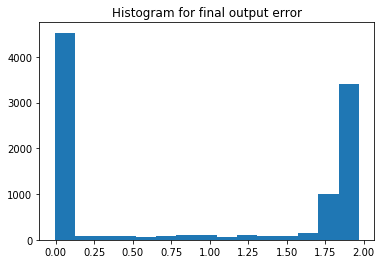

In [152]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()